In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocesamiento y Pipelines
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     TimeSeriesSplit, RandomizedSearchCV, 
                                     cross_val_score)
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from scipy.stats.mstats import winsorize
from sklearn.calibration import CalibratedClassifierCV

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import TweedieRegressor

# Métricas y Interpretabilidad
from sklearn.metrics import (classification_report, roc_auc_score, f1_score, 
                             precision_recall_curve, auc, r2_score, 
                             mean_squared_error)
import shap

In [15]:
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
RANDOM_STATE = 42


In [16]:
try:
    project_root = Path.cwd().parent
    processed_path = project_root / "data" / "processed"
    
    df_full = pd.read_csv(processed_path / "features_clasificacion.csv")
    df_reg = pd.read_csv(processed_path / "features_regresion.csv")
    
    print("Datasets cargados exitosamente.")
    print(f"Forma del dataset de clasificación: {df_full.shape}")
    print(f"Forma del dataset de regresión: {df_reg.shape}")

except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. Verifica la ruta: {e}")
    df_full = None
    df_reg = None

Datasets cargados exitosamente.
Forma del dataset de clasificación: (30000, 46)
Forma del dataset de regresión: (30000, 29)



--- Iniciando Modelado de Clasificación Avanzado ---

--- Buscando mejores hiperparámetros para Random Forest ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Mejores parámetros encontrados para Random Forest: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10, 'classifier__class_weight': 'balanced_subsample'}

--- Calibrando probabilidades del mejor modelo ---

--- Optimizando umbral de decisión ---


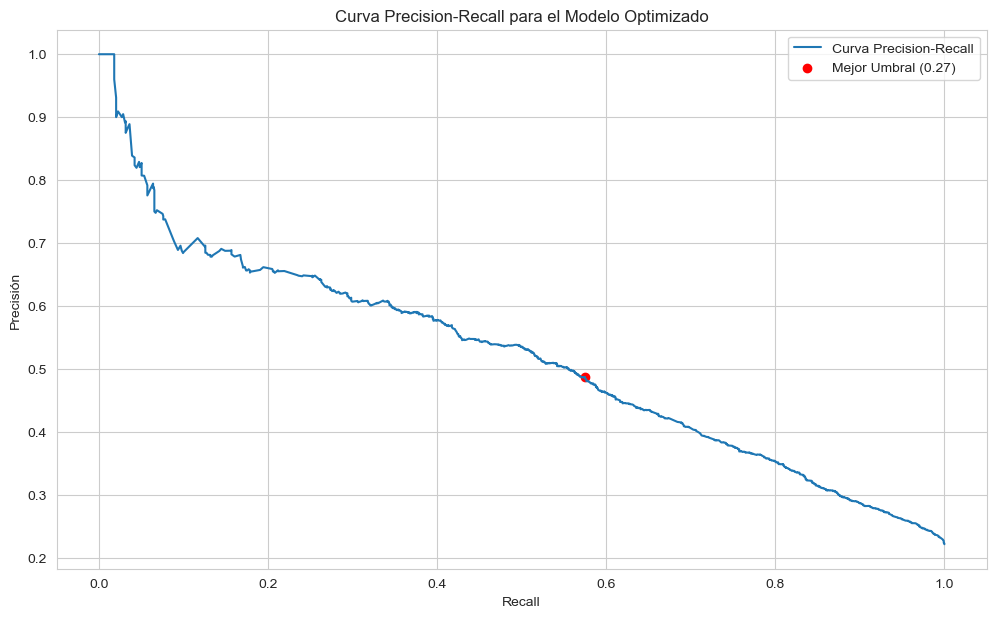

Umbral óptimo que maximiza F1-Score: 0.2730

--- Reporte de Clasificación Final (con umbral optimizado) ---
                   precision    recall  f1-score   support

No Incumplimiento       0.87      0.83      0.85      4673
   Incumplimiento       0.49      0.57      0.53      1327

         accuracy                           0.77      6000
        macro avg       0.68      0.70      0.69      6000
     weighted avg       0.79      0.77      0.78      6000


--- Análisis de Interpretabilidad con SHAP ---


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [20]:

if df_full is not None:
    print("\n--- Iniciando Modelado de Clasificación Avanzado ---")
    
    # --- 3.1. Preparación de Datos ---
    X = df_full.select_dtypes(include=np.number).drop(columns=['default_payment_next_month', 'ID'])
    y = df_full['default_payment_next_month']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    # --- 3.2. Búsqueda de Hiperparámetros con Pipeline y Validación Cruzada Estratificada ---
    print("\n--- Buscando mejores hiperparámetros para Random Forest ---")
    
    # Pipeline con muestreo avanzado, escalado y clasificador
    pipeline_rf = ImbPipeline([
        ('sampler', SMOTEENN(random_state=RANDOM_STATE)),
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ])
    
    # Parrilla de parámetros para RandomizedSearchCV
    param_dist_rf = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': ['balanced', 'balanced_subsample', None]
    }
    
    # Validación cruzada estratificada
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE) # 3 splits para agilizar
    
    random_search_rf = RandomizedSearchCV(
        estimator=pipeline_rf,
        param_distributions=param_dist_rf,
        n_iter=10, # 10 iteraciones para una búsqueda rápida
        cv=skf,
        scoring='f1_macro',
        verbose=1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    random_search_rf.fit(X_train, y_train)
    best_clf = random_search_rf.best_estimator_
    print(f"\nMejores parámetros encontrados para Random Forest: {random_search_rf.best_params_}")

    # --- 3.3. Calibración de Probabilidades ---
    print("\n--- Calibrando probabilidades del mejor modelo ---")
    calibrated_clf = CalibratedClassifierCV(best_clf, method='isotonic', cv=skf)
    calibrated_clf.fit(X_train, y_train)
    y_pred_proba_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]

    # --- 3.4. Optimización de Umbral y Visualización de Curva PR ---
    print("\n--- Optimizando umbral de decisión ---")
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_calibrated)
    f1_scores = (2 * recall * precision) / (recall + precision + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    plt.figure()
    plt.plot(recall, precision, label='Curva Precision-Recall')
    plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', color='red', label=f'Mejor Umbral ({optimal_threshold:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title('Curva Precision-Recall para el Modelo Optimizado')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Umbral óptimo que maximiza F1-Score: {optimal_threshold:.4f}")
    
    # --- 3.5. Evaluación Final del Modelo de Clasificación ---
    y_pred_optimal = (y_pred_proba_calibrated >= optimal_threshold).astype(int)
    print("\n--- Reporte de Clasificación Final (con umbral optimizado) ---")
    print(classification_report(y_test, y_pred_optimal, target_names=['No Incumplimiento', 'Incumplimiento']))

    # --- 3.6. Interpretabilidad con SHAP ---
    print("\n--- Análisis de Interpretabilidad con SHAP ---")
    # SHAP requiere un modelo base, extraemos el clasificador del pipeline
    # y lo re-entrenamos en los datos transformados para la explicación.
    sampler = best_clf.named_steps['sampler']
    scaler = best_clf.named_steps['scaler']
    model = best_clf.named_steps['classifier']
    
    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
    X_train_scaled = scaler.fit_transform(X_train_res)
    model.fit(X_train_scaled, y_train_res) # Re-entrenamiento para SHAP
    
    X_test_scaled = scaler.transform(X_test)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_scaled)
    shap_vals_class1 = shap_values[1][:, :X_test_scaled.shape[1]]
    shap.summary_plot(
        shap_vals_class1,
        features=X_test_scaled,
        feature_names=X_test.columns,
        plot_type="bar",
        max_display=15
    )
    
    print("Generando gráfico de resumen de SHAP (Clase 1: Incumplimiento)...")
    # CORRECCIÓN: Se pasa el array escalado (X_test_scaled) y los nombres de las columnas
    # por separado para evitar el error de aserción de forma.
    shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X_test.columns, plot_type="bar", max_display=15)

In [18]:
if df_reg is not None:
    print("\n--- Iniciando Modelado de Regresión Avanzado (Hurdle Model) ---")
    
    # --- 4.1. Preparación de Datos ---
    X_reg = df_reg.select_dtypes(include=np.number).drop(columns=['pay_amt_june', 'ID'])
    y_reg = df_reg['pay_amt_june']
    
    y_hurdle_class = (y_reg > 0).astype(int)
    df_reg_pos = df_reg[df_reg['pay_amt_june'] > 0]
    X_reg_pos = df_reg_pos.select_dtypes(include=np.number).drop(columns=['pay_amt_june', 'ID'])
    y_reg_pos = df_reg_pos['pay_amt_june']
    
    X_train_reg, X_test_reg, y_train_hurdle_class, y_test_hurdle_class, y_train_reg_orig, y_test_reg_orig = train_test_split(
        X_reg, y_hurdle_class, y_reg, test_size=0.2, random_state=RANDOM_STATE, stratify=y_hurdle_class
    )
    X_train_reg_pos, X_test_reg_pos, y_train_reg_pos, y_test_reg_pos = train_test_split(
        X_reg_pos, y_reg_pos, test_size=0.2, random_state=RANDOM_STATE
    )

    # --- 4.2. Etapa 1: Entrenamiento del Clasificador del Obstáculo ---
    print("\n--- Entrenando Etapa 1: Clasificador del Obstáculo ---")
    scale_pos_weight_hurdle = y_train_hurdle_class.value_counts()[0] / y_train_hurdle_class.value_counts()[1]
    pipeline_hurdle_class = ImbPipeline([
        ('sampler', SMOTEENN(random_state=RANDOM_STATE)),
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_hurdle))
    ])
    pipeline_hurdle_class.fit(X_train_reg, y_train_hurdle_class)
    
    # --- 4.3. Etapa 2: Entrenamiento del Regresor de Monto con Validación Temporal ---
    print("\n--- Entrenando Etapa 2: Regresor de Monto ---")
    
    # Aplicar winsorización para tratar outliers
    y_train_reg_pos_win = winsorize(y_train_reg_pos, limits=[0.01, 0.01])
    
    # Pipeline para el regresor
    pipeline_reg = Pipeline([
        ('scaler', StandardScaler()),
        ('transformer', PowerTransformer(method='yeo-johnson')), # Transformación flexible
        ('regressor', HistGradientBoostingRegressor(random_state=RANDOM_STATE)) # Modelo robusto a outliers
    ])
    
    # Validación cruzada temporal
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = cross_val_score(pipeline_reg, X_train_reg_pos, y_train_reg_pos_win, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f"RMSE Promedio en Validación Cruzada Temporal: {-np.mean(rmse_scores):.2f}")
    
    # Entrenamiento final del regresor
    pipeline_reg.fit(X_train_reg_pos, y_train_reg_pos_win)

    # --- 4.4. Combinación y Evaluación Final del Modelo ---
    print("\n--- Evaluación Final del Modelo de Obstáculo Combinado ---")
    pred_paga_o_no = pipeline_hurdle_class.predict(X_test_reg)
    pred_monto_si_paga = pipeline_reg.predict(X_test_reg)
    final_predictions = pred_monto_si_paga * pred_paga_o_no
    
    r2_hurdle = r2_score(y_test_reg_orig, final_predictions)
    rmse_hurdle = np.sqrt(mean_squared_error(y_test_reg_orig, final_predictions))
    
    print(f"R² Score Final: {r2_hurdle:.4f}")
    print(f"RMSE Final: {rmse_hurdle:.4f}")


--- Iniciando Modelado de Regresión Avanzado (Hurdle Model) ---

--- Entrenando Etapa 1: Clasificador del Obstáculo ---


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:29:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Entrenando Etapa 2: Regresor de Monto ---
RMSE Promedio en Validación Cruzada Temporal: 4926.10

--- Evaluación Final del Modelo de Obstáculo Combinado ---
R² Score Final: 0.6068
RMSE Final: 10037.6391
